In [69]:
import cv2
import numpy as np
import sys
import getopt
import operator
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpim
from scipy import ndimage

In [122]:
def read_image(img_name):
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

In [70]:
def getMatrix(matrix, curr_x, curr_y, v_boundary,  h_boundary):
    return matrix[curr_x - v_boundary:curr_x + h_boundary,curr_y - v_boundary: curr_y + h_boundary]


def findCorners(img, window_size, k, thresh):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    #Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]
    saved_responses = np.zeros((height, width))
    newImg = img.copy()
    color_img = cv2.cvtColor(newImg, cv2.COLOR_GRAY2RGB)
    offset = math.floor(window_size/2)

    
    # Loop through image and find our corners
    # and do non-maximum suppression
    # this can be also implemented without loop
    
    print("Finding Corners...")
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            X_component = getMatrix(Ixx, y,x, offset, offset+1)
            Y_component = getMatrix(Iyy, y,x, offset, offset+1)
            XY_component = getMatrix(Ixy, y,x, offset, offset+1)

            Mxx = np.sum(X_component)
            Myy = np.sum(Y_component)
            Mxy = np.sum(XY_component)

            determinant = (Mxx * Myy) - (Mxy**2)
            trace = Mxx + Myy
            response = determinant - k * (trace**2)
            saved_responses.itemset((y,x),response)
    

    non_maximum_suppressed_array = ndimage.rank_filter(saved_responses, rank=-1, footprint=np.ones((window_size,window_size)))
    suppression_mask = np.array(non_maximum_suppressed_array == saved_responses).astype(int)
    suppressed_response_values = suppression_mask * saved_responses
    filtered_by_threshold = np.array(suppressed_response_values > thresh).astype(int) * saved_responses

    return color_img, filtered_by_threshold

In [91]:
def findGradMagnitude(img):
    Iy, Ix = np.gradient(img) 
    sum_of_squares =  np.square(Iy) + np.square(Ix)
    gradient_magnitude = np.sqrt(sum_of_squares)
    return gradient_magnitude

In [112]:
def findOrientation(img):
    Iy, Ix = np.gradient(img)
    # plt.imshow(Ix,cmap='gray')
    theta = np.rad2deg(np.arctan2(Iy,Ix))
    return theta

In [123]:
harris_corner_dir = "harris_corner_images"
grad_magnitude_dir = "grad_magnitude_images"
grad_orientation_dir = "grad_orientation_images"
Ix_dir = "Ix"
Iy_dir = "Iy"

def main(window_size, k, img_name, thresh):
    """
    Main parses argument list and runs findCorners() on the image
    :return: None
    """
    # args, img_name = getopt.getopt(sys.argv[1:], '', ['window_size=', 'alpha=', 'corner_threshold='])
    # args = dict(args)
    # print(args)


    print("Image Name: " + str(img_name))
    print("Window Size: " + str(window_size))
    print("K alpha: " + str(k))
    print("Corner Response Threshold:" + str(thresh))

    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(img.shape[0], img.shape[1])
    finalImg, filtered_by_threshold = findCorners(img, int(window_size), float(k), int(thresh))

    points = np.where(filtered_by_threshold > thresh)
    plot = plt.figure(1)
    plt.imshow(img, cmap="gray")
    plt.plot(points[1],points[0], 'b.', markersize = 0.4)
    plt.show()

    image_mask = np.zeros((finalImg.shape[0], finalImg.shape[1], finalImg.shape[2]))
    image_mask[:, :, 2] = filtered_by_threshold * 255.0
    image_mask[:, :, 1] = filtered_by_threshold * (-1000)
    image_mask[:, :, 0] = filtered_by_threshold * (-1000)

    changed_corner_values = finalImg + image_mask
    corner_values_clipped = np.clip(changed_corner_values, a_min=0, a_max=255)
         
    if corner_values_clipped is not None:
            cv2.imwrite(str(img_name+".png"), corner_values_clipped)


    grad_magnitude = findGradMagnitude(img)
    grad_orientation = findOrientation(img)
    # plt.imshow(grad_orientation, cmap='gray')

    if corner_values_clipped is not None:
            cv2.imwrite("grad_magnitude.png", grad_magnitude)

    if grad_orientation is not None:
            cv2.imwrite("grad_orientation.png", grad_orientation)

Image Name: hw3_images/house1-rotated.jpg
Window Size: 5
K alpha: 0.04
Corner Response Threshold:100000
1280 960
Finding Corners...


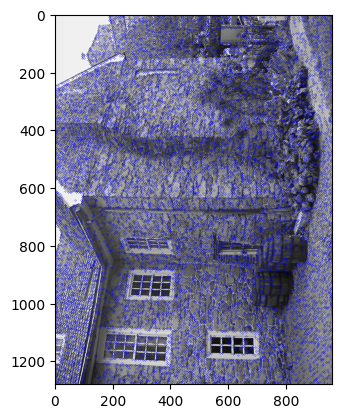

In [124]:
window_size = 5
k = 0.04
thresh = 100000
img_name = "hw3_images/house1-rotated.jpg"
main(window_size, k, img_name, thresh)

In [111]:
# np.where(pts>0)